<a href="https://colab.research.google.com/github/tfarotimi/Tope-Farotimi-MLE/blob/main/fuel_efficiency.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<p align = "center" draggable=”false” ><img src="https://user-images.githubusercontent.com/37101144/161836199-fdb0219d-0361-4988-bf26-48b0fad160a3.png" 
     width="200px"
     height="auto"/>
</p>

# ⛽ Fuel efficiency Prediction

Provided with the classic [Auto MPG](https://archive.ics.uci.edu/ml/datasets/auto+mpg) dataset, we will predict the **fuel efficiency** of the late-1970s and early 1980s automobiles, leveraging features such as cylinders, displacement, horsepower, weight, etc. 

It is a very small dataset and there are only a few features. We will first build a linear model and a neural network, evaluate their performances, track our experiment runs and inspect the logs using MLflow, and apply [TPOT](https://github.com/EpistasisLab/tpot) to see how it can be used to search over many ML model architectures, followed by explaining the model with SHAP.

# 📚 Learning Objectives

By the end of this session, you will be able to

- understand the core building blocks of a neural network
- understand what dense and activation layers do
- build, train, and evaluate neural networks
- track tensorflow experiments with MLflow, access information of runs programmatically and with its tracking ui
- perform AutoML to search for optimal tree-based pipeline for a regression task 

Note: [State of Data Science and Machine Learning 2021](https://www.kaggle.com/kaggle-survey-2021) by Kaggle shows that the most commonly used algorithms were linear and logtistic regressions, followed closely by decision trees, random forests, and gradient boosting machines (are you surprised?). Multilayer perceptron, or artificial neural networks are not yet the popular tools for tabular/structured data; see more technical reasons in papers: [Deep Neural Networks and Tabular Data: A Survey](https://arxiv.org/abs/2110.01889), [Tabular Data: Deep Learning is Not All You Need](https://arxiv.org/abs/2106.03253). For this assignment, the main purpose is for you to get familiar with the basic building blocks in constructing neural networks before we dive into more specialized neural network architectures.


**IMPORTANT**

You only need to run the following cells if you're completing the assignment in Google Collab. If you've already installed these libraries locally, you can skip installing these libraries.

In [3]:
# Connect colab to your Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
!pip install -q seaborn # pairplot
!pip install -q tpot  # automl

!pip install -q mlflow # tracking
!pip install -q pyngrok # workaround to run mlflow ui in colab
!pip install -q shap

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 87.2/87.2 KB 4.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.9/139.9 KB 10.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 193.6/193.6 MB 6.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.7/16.7 MB 70.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 210.6/210.6 KB 21.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 575.9/575.9 KB 41.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 147.5/147.5 KB 15.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 82.3/82.3 KB 9.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 184.0/184.0 KB 19.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.5/79.5 KB 9.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.7/78.7 KB 8.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━

In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Make NumPy printouts easier to read.
np.set_printoptions(precision=3, suppress=True)

In [6]:
import tensorflow as tf
from tensorflow.keras import layers
from sklearn import metrics

print(tf.__version__)

2.9.2


# Task 1 - Data: Auto MPG dataset

0. Start MLflow's automatic logging using library-specific autolog calls for tensorflow: logging metrics, parameters, and models without the need for explicit log statements. 
    
    We will get into more details using **MLflow** after completing our experiment.

In [7]:
import mlflow
mlflow.tensorflow.autolog() # MLflow Autologging

1. The dataset is available from the [UCI Machine Learning Repository](https://archive.ics.uci.edu/ml/). First download and import the dataset using `pandas`:


In [8]:
url = 'http://archive.ics.uci.edu/ml/machine-learning-databases/auto-mpg/auto-mpg.data'
column_names = [
  'MPG', 'Cylinders', 'Displacement', 'Horsepower', 'Weight',
  'Acceleration', 'Model Year', 'Origin'
  ]

dataset = pd.read_csv(url, names=column_names, na_values='?', 
                      comment='\t', sep=' ', skipinitialspace=True)

In [9]:
dataset.tail()

,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,Origin
393,27.0,4,140.0,86.0,2790.0,15.6,82,1
394,44.0,4,97.0,52.0,2130.0,24.6,82,2
395,32.0,4,135.0,84.0,2295.0,11.6,82,1
396,28.0,4,120.0,79.0,2625.0,18.6,82,1
397,31.0,4,119.0,82.0,2720.0,19.4,82,1


2. The dataset contains a few unknown values, we drop those rows to keep this initial tutorial simple. Use `pd.DataFrame.dropna()`:

In [10]:
dataset = dataset.dropna() # YOUR CODE HERE
dataset.shape
dataset.info()
dataset.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 392 entries, 0 to 397
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   MPG           392 non-null    float64
 1   Cylinders     392 non-null    int64  
 2   Displacement  392 non-null    float64
 3   Horsepower    392 non-null    float64
 4   Weight        392 non-null    float64
 5   Acceleration  392 non-null    float64
 6   Model Year    392 non-null    int64  
 7   Origin        392 non-null    int64  
dtypes: float64(5), int64(3)
memory usage: 27.6 KB


,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,Origin
0,18.0,8,307.0,130.0,3504.0,12.0,70,1
1,15.0,8,350.0,165.0,3693.0,11.5,70,1
2,18.0,8,318.0,150.0,3436.0,11.0,70,1
3,16.0,8,304.0,150.0,3433.0,12.0,70,1
4,17.0,8,302.0,140.0,3449.0,10.5,70,1


3. The `"Origin"` column is categorical, not numeric. So the next step is to one-hot encode the values in the column with [pd.get_dummies](https://pandas.pydata.org/docs/reference/api/pandas.get_dummies.html).

In [11]:
dataset['Origin'] = dataset['Origin'].replace({1: 'USA', 2: 'Europe', 3: 'Japan'})

<ipython-input-11-5c26c4470533>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset['Origin'] = dataset['Origin'].replace({1: 'USA', 2: 'Europe', 3: 'Japan'})


In [12]:
dataset = pd.get_dummies(dataset, columns=['Origin'], prefix='', prefix_sep='')
dataset.tail()


,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,Europe,Japan,USA
393,27.0,4,140.0,86.0,2790.0,15.6,82,0,0,1
394,44.0,4,97.0,52.0,2130.0,24.6,82,1,0,0
395,32.0,4,135.0,84.0,2295.0,11.6,82,0,0,1
396,28.0,4,120.0,79.0,2625.0,18.6,82,0,0,1
397,31.0,4,119.0,82.0,2720.0,19.4,82,0,0,1


4. Split the data into training and test sets. To reduce the module importing overhead, instead of `sklearn.model_selection.train_test_split()`, use `pd.DataFrame.sample()` to save 80% of the data aside to `train_dataset`, set the random state to be 0 for reproducibility. 

   Then use `pd.DataFrame.drop()` to obtain the `test_dataset`.

In [13]:
train_dataset = dataset.sample(frac=0.8) # YOUR CODE HERE
test_dataset = dataset.sample(frac=0.2) # YOUR CODE HERE
train_dataset.shape, test_dataset.shape

((314, 10), (78, 10))

5. Review the pairwise relationships of a few pairs of columns from the training set. 
   
   The top row suggests that the fuel efficiency (MPG) is a function of all the other parameters. The other rows indicate they are functions of each other.

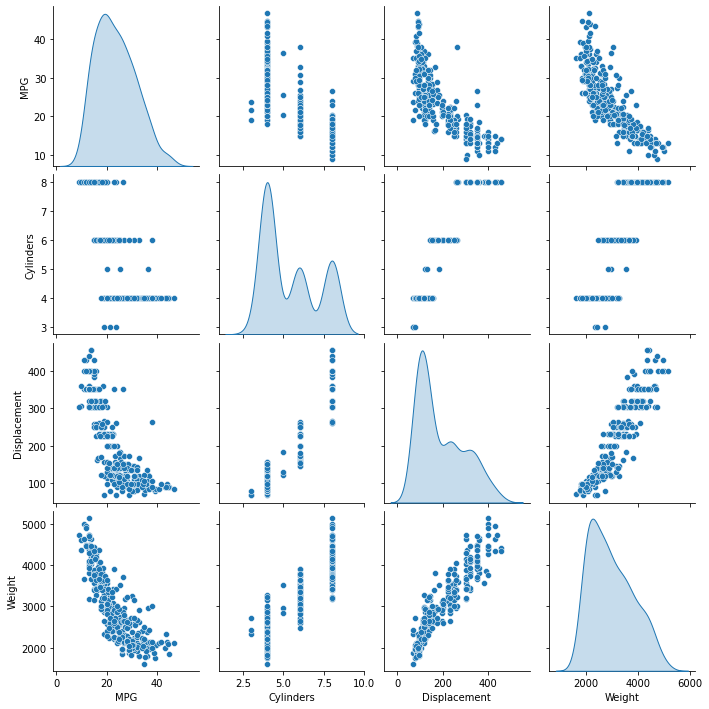

In [14]:
sns.pairplot(train_dataset[['MPG', 'Cylinders', 'Displacement', 'Weight']], diag_kind='kde');

Let's also check the overall statistics. Note how each feature covers a very different range:

In [15]:
train_dataset.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
MPG,314.0,23.634076,7.830530,9.0,18.000,23.0,29.00,46.6
Cylinders,314.0,5.439490,1.679942,3.0,4.000,4.0,6.00,8.0
Displacement,314.0,192.157643,101.959969,68.0,105.000,148.5,259.50,455.0
Horsepower,314.0,103.187898,37.217001,46.0,76.000,92.0,120.00,230.0
Weight,314.0,2969.898089,829.498772,1613.0,2233.750,2834.0,3568.25,5140.0
Acceleration,314.0,15.658599,2.811854,8.5,13.825,15.5,17.30,24.8
Model Year,314.0,76.111465,3.689679,70.0,73.000,76.0,79.00,82.0
Europe,314.0,0.184713,0.388684,0.0,0.000,0.0,0.00,1.0
Japan,314.0,0.184713,0.388684,0.0,0.000,0.0,0.00,1.0
USA,314.0,0.630573,0.483420,0.0,0.000,1.0,1.00,1.0


6. Split features from labels. 
  This means, separate the target value(also called"label") from the features. 
  Label is the value that you will train the model to predict.

In [16]:
train_features = train_dataset.drop(['MPG'],axis=1) # YOUR CODE HERE
test_features = test_dataset.drop(['MPG'],axis=1)# YOUR CODE HERE

train_labels = train_dataset['MPG'] # YOUR CODE HERE
test_labels = test_dataset['MPG'] # YOUR CODE HERE

# Task 2 - Normalization Layer

It is good practice to normalize features that use different scales and ranges. Although a model *might* converge without feature normalization, normalization makes training much more stable.

Similar to scikit-learn, tensorflow.keras offers a list of [preprocessing layers](https://www.tensorflow.org/guide/keras/preprocessing_layers) so that you can build and export models that are truly end-to-end.

1. The Normalization layer ([`tf.keras.layers.Normalization`](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Normalization) is a clean and simple way to add feature normalization into your model. The first step is to create the layer:

In [17]:
normalizer = layers.Normalization() # YOUR CODE HERE

2. Then, fit the state of the preprocessing layer to the data by calling [`Normalization.adapt`](https://www.tensorflow.org/guide/keras/preprocessing_layers#the_adapt_method):

In [18]:
normalizer.adapt(train_features)
train_features.head()

,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,Europe,Japan,USA
45,6,258.0,110.0,2962.0,13.5,71,0,0,1
269,4,105.0,75.0,2230.0,14.5,78,0,0,1
313,4,151.0,90.0,2678.0,16.5,80,0,0,1
179,4,121.0,98.0,2945.0,14.5,75,1,0,0
161,6,250.0,105.0,3897.0,18.5,75,0,0,1


We can see the feature mean and variance are stored in the layer:

In [19]:
print(f'feature mean: {normalizer.mean.numpy().squeeze()}\n')
print(f'feature variance: {normalizer.variance.numpy().squeeze()}')

feature mean: [   5.439  192.158  103.188 2969.898   15.659   76.111    0.185    0.185
    0.631]

feature variance: [     2.813  10362.726   1380.694 685876.94       7.881     13.57
      0.151      0.151      0.233]


When the layer is called, it returns the input data, with each feature independently normalized:

In [20]:
first = np.array(train_features[:1])

with np.printoptions(precision=2, suppress=True):
    print('First example:', first)
    print()
    print('Normalized:', normalizer(first).numpy())

First example: [[   6.   258.   110.  2962.    13.5   71.     0.     0.     1. ]]

Normalized: [[ 0.33  0.65  0.18 -0.01 -0.77 -1.39 -0.48 -0.48  0.77]]


# Task 3 - Linear Regression 📈

Before building a deep neural network model, start with linear regression using all the features.

Training a model with `tf.keras` typically starts by defining the model architecture. Use a `tf.keras.Sequential` model, which [represents a sequence of steps](https://www.tensorflow.org/guide/keras/sequential_model).

There are two steps in this multivariate linear regression model:

- Normalize all the input features using the `tf.keras.layers.Normalization` preprocessing layer. You have defined this earlier as `normalizer`.
- Apply a linear transformation ($y = mx+b$ where $m$ is a matrix and $b$ is a vector.) to produce one output using a linear layer ([`tf.keras.layers.Dense`](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Dense)).

The number of _inputs_ can either be set by the `input_shape` argument, or automatically when the model is run for the first time.

1. Build the Keras Sequential model:

In [21]:
linear_model = tf.keras.Sequential([
     layers.Input(shape=len(train_features.columns) , ),
     layers.Normalization(),
     layers.Dense(1),
    # YOUR CODE HERE
])

In [22]:
linear_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization_1 (Normalizat  (None, 9)                19        
 ion)                                                            
                                                                 
 dense (Dense)               (None, 1)                 10        
                                                                 
Total params: 29
Trainable params: 10
Non-trainable params: 19
_________________________________________________________________


2. This model will predict `'MPG'` from all features in `train_features`. Run the untrained model on the first 10 data points / rows using `Model.predict()`. The output won't be good, but notice that it has the expected shape of `(10, 1)`:

In [23]:
# YOUR CODE HERE
display(linear_model.predict(train_features[:10]))

1/1 [==============================] - 0s 156ms/step


array([[-1070.842],
       [ -761.63 ],
       [ -928.903],
       [-1010.012],
       [-1366.249],
       [-1036.527],
       [-1668.862],
       [-1285.313],
       [ -993.39 ],
       [ -746.67 ]], dtype=float32)

3. When you call the model, its weight matrices will be built—check that the `kernel` weights (the $m$ in $y = mx + b$) have a shape of (9, 1):

In [24]:
linear_model.layers[1].kernel

<tf.Variable 'dense/kernel:0' shape=(9, 1) dtype=float32, numpy=
array([[ 0.457],
       [-0.348],
       [-0.481],
       [-0.324],
       [ 0.177],
       [ 0.384],
       [ 0.378],
       [-0.461],
       [-0.735]], dtype=float32)>

4. Once the model is built, configure the training procedure using the Keras `Model.compile` method. The most important arguments to compile are the `loss` and the `optimizer`, since these define what will be optimized and how (using the `tf.keras.optimizers.Adam`).

  Here's a list of built-in loss functions in [`tf.keras.losses`](https://www.tensorflow.org/api_docs/python/tf/keras/losses). For regression tasks, [common loss functions](https://towardsdatascience.com/understanding-the-3-most-common-loss-functions-for-machine-learning-regression-23e0ef3e14d3) include mean squared error (MSE) and mean absolute error (MAE). Here,  MAE is preferred such that the model is more robust against outliers. 

  For optimizers, gradient descent (check this video [Gradient Descent, Step-by-Step](https://www.youtube.com/watch?v=sDv4f4s2SB8) for a refresher) is the preferred way to optimize neural networks and many other machine learning algorithms. Read [an overview of graident descent optimizer algorithms](https://ruder.io/optimizing-gradient-descent/) for several popular gradient descent algorithms. Here, we use the popular [`tf.keras.optimizers.Adam`](https://www.tensorflow.org/api_docs/python/tf/keras/optimizers/Adam), and set the learning rate at 0.1 for faster learning.  

In [25]:
linear_model.compile(
    optimizer='adam', # YOUR CODE HERE
    loss='mean_absolute_error' # YOUR CODE HERE
    )

5. Use Keras `Model.fit` to execute the training for 100 epochs, set the verbose to 0 to suppress logging and keep 20% of the data for validation:

In [26]:
%%time
history = linear_model.fit(train_features, train_labels, epochs=100,verbose=0,batch_size=32, validation_data = (test_features, test_labels)) # YOUR CODE HERE

2023/02/01 04:58:48 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID '53e34ecda9b34ab4975b1b7d7459d094', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current tensorflow workflow
2023/02/01 04:59:00 WARNING mlflow.tensorflow: Failed to infer model signature: could not sample data to infer model signature: Cannot log input example or model signature for input with type <class 'pandas.core.frame.DataFrame'>. TensorFlow Keras autologging can only log input examples and model signatures for the following input types: numpy.ndarray, dict[string -> numpy.ndarray], tensorflow.keras.utils.Sequence, and tensorflow.data.Dataset (TensorFlow >= 2.1.0 required)
2023/02/01 04:59:00 WARNING mlflow.tensorflow: You are saving a TensorFlow Core model or Keras model without a signature. Inference with mlflow.pyfunc.spark_udf() will not work unless the model's pyfunc representation accepts pandas DataFrames as inference i

CPU times: user 7.85 s, sys: 437 ms, total: 8.29 s
Wall time: 18 s


6. Visualize the model's training progress using the stats stored in the `history` object:

In [27]:
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist.tail()

,loss,val_loss,epoch
95,3.297719,3.401963,95
96,3.288032,3.576806,96
97,3.341700,3.278636,97
98,3.245152,3.338542,98
99,3.222416,3.296942,99


In [28]:
def plot_loss(history):
    plt.plot(history.history['loss'], label='loss')
    plt.plot(history.history['val_loss'], label='val_loss')
    plt.ylim([0, 10])
    plt.xlabel('Epoch')
    plt.ylabel('Error [MPG]')
    plt.legend()
    plt.grid(True)

Use `plot_loss(history)` provided to visualize the progression in loss function for training and validation data sets. 

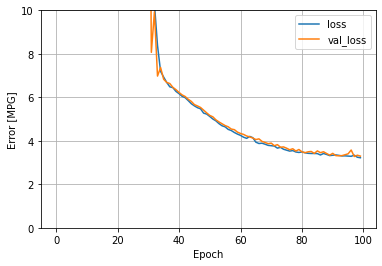

In [29]:
# YOUR CODE HERE
plot_loss(history)

7. Collect the results on the test set for later using [`Model.evaluate()`](https://www.tensorflow.org/api_docs/python/tf/keras/Model#evaluate)

In [30]:
test_results = {}

test_results['linear_model'] = linear_model.evaluate(x=test_features.values, y=test_labels.values) # YOUR CODE HERE

3/3 [==============================] - 0s 4ms/step - loss: 3.2969


In [31]:
test_results

{'linear_model': 3.2969419956207275}

# Task 4 - Regression with a Deep Neural Network (DNN)

You just implemented a linear model for multiple inputs. Now, you are ready to implement multiple-input DNN models.

The code is very similar except the model is expanded to include some "hidden" **non-linear** layers. The name "hidden" here just means not directly connected to the inputs or outputs.

* The normalization layer, as before (with `normalizer` for a multiple-input model).
* Two hidden, non-linear, [`Dense`](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Dense) layers with the ReLU (`relu`) activation function nonlinearity. One way is to set parameter `activation` inside `Dense` Set the number of neurons at each layer to be 64. 
* A linear `Dense` single-output layer. 



1. Include the model and `compile` method in the `build_and_compile_model` function below. 

In [32]:
def build_and_compile_model(norm):
    model = tf.keras.Sequential([
        # YOUR CODE HERE
        tf.keras.Input(shape=(len(train_features.columns, ))),
        layers.Normalization(),
        tf.keras.layers.Dense(64, activation = 'relu'),
        tf.keras.layers.Dense(64, activation = 'relu'), 
        tf.keras.layers.Dense(1)
    ])

    model.compile(loss='mean_absolute_error',
                optimizer=tf.keras.optimizers.Adam())
    return model

2. Create a DNN model with `normalizer` (defined earlier) as the normalization layer:



In [33]:
dnn_model = build_and_compile_model(normalizer) # YOUR CODE HERE

3. Inspect the model using `Model.summary()`. This model has quite a few more trainable parameters than the linear models:

In [34]:
# YOUR CODE HERE
dnn_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization_2 (Normalizat  (None, 9)                19        
 ion)                                                            
                                                                 
 dense_1 (Dense)             (None, 64)                640       
                                                                 
 dense_2 (Dense)             (None, 64)                4160      
                                                                 
 dense_3 (Dense)             (None, 1)                 65        
                                                                 
Total params: 4,884
Trainable params: 4,865
Non-trainable params: 19
_________________________________________________________________


4. Train the model with Keras `Model.fit`:

In [35]:
%%time
history = dnn_model.fit(
    train_features,
    train_labels,
    validation_split=0.2,
    verbose=0, epochs=100)

2023/02/01 04:59:06 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID '42a95d22850d4b21b512affbce56ec13', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current tensorflow workflow
2023/02/01 04:59:12 WARNING mlflow.tensorflow: Failed to infer model signature: could not sample data to infer model signature: Cannot log input example or model signature for input with type <class 'pandas.core.frame.DataFrame'>. TensorFlow Keras autologging can only log input examples and model signatures for the following input types: numpy.ndarray, dict[string -> numpy.ndarray], tensorflow.keras.utils.Sequence, and tensorflow.data.Dataset (TensorFlow >= 2.1.0 required)
2023/02/01 04:59:12 WARNING mlflow.tensorflow: You are saving a TensorFlow Core model or Keras model without a signature. Inference with mlflow.pyfunc.spark_udf() will not work unless the model's pyfunc representation accepts pandas DataFrames as inference i

CPU times: user 5.44 s, sys: 267 ms, total: 5.7 s
Wall time: 11.1 s


5. Visualize the model's training progress using the stats stored in the history object. 

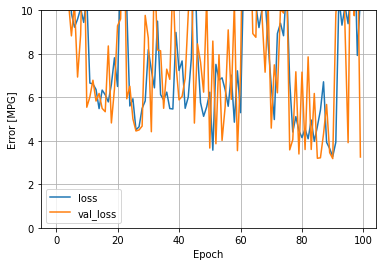

In [36]:
plot_loss(history)

Do you think the DNN model is overfitting? What gives away? 

    *YOUR ANSWER HERE*

6. Let's save the results for later comparison.

In [37]:
test_results['dnn_model'] = dnn_model.evaluate(test_features, test_labels, verbose=0)

# Task 5 - Make Predictions 🔮

1. Since both models have been trained, we can review their test set performance:

In [38]:
pd.DataFrame(test_results, index=['Mean absolute error [MPG]']).T

,Mean absolute error [MPG]
linear_model,3.296942
dnn_model,2.910134


These results match the validation error observed during training.

2. We can now make predictions with the `dnn_model` on the test set using Keras `Model.predict` and review the loss. Use `.flatten()`.

3/3 [==============================] - 0s 4ms/step


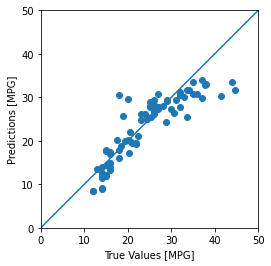

In [39]:
test_predictions = dnn_model.predict(test_features) # YOUR CODE HERE
test_predictions
a = plt.axes(aspect='equal')
plt.scatter(test_labels, test_predictions)
plt.xlabel('True Values [MPG]')
plt.ylabel('Predictions [MPG]')
lims = [0, 50]
plt.xlim(lims)
plt.ylim(lims)
_ = plt.plot(lims, lims)


3. It appears that the model predicts reasonably well. Now, check the error distribution:

In [40]:
#from sklearn import metrics
#metrics.(test_predictions,test_labels)

Text(0, 0.5, 'Count')

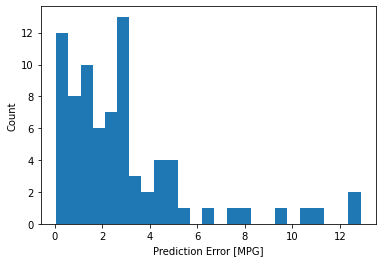

In [41]:

test_pred_array = np.array(test_predictions).reshape(78)
test_label_array = np.array(test_labels).reshape(78)
error = np.abs(np.subtract(test_pred_array,test_label_array))#YOUR CODE HERE
error
plt.hist(error, bins=25)

plt.xlabel('Prediction Error [MPG]')
plt.ylabel('Count')

4. Save it for later use with `Model.save`:

In [42]:
dnn_model.save('dnn_model')

5. Reload the model with `Model.load_model`; it gives identical output:

In [43]:
reloaded = tf.keras.models.load_model('dnn_model') # YOUR CODE HERE

test_results['reloaded'] = reloaded.evaluate(
    test_features, test_labels, verbose=0)

test_results

{'linear_model': 3.2969419956207275,
 'dnn_model': 2.9101343154907227,
 'reloaded': 2.9101343154907227}

In [44]:
pd.DataFrame(test_results, index=['Mean absolute error [MPG]']).T

,Mean absolute error [MPG]
linear_model,3.296942
dnn_model,2.910134
reloaded,2.910134


# Task 6 - Nonlinearity

We mentioned that the `relu` activation function introduce non-linearity; let's visualize it. Since there are six numerical features and 1 categorical features, it is impossible to plot all the dimensions on a 2D plot; we need to simplify/isolate it. 

Note: in this task, code is provided; the focus in on understanding. 

1. We focus on the relationship between feature `Displacement` and target `MPG`. 
  
  To do so, create a new dataset of the same size as `train_features`, but all other features are set at their median values; then set the `Displacement` between 0 and 500. 

In [45]:
x = np.outer(np.ones(train_features.shape[0]),train_features.median())
fake = np.outer(np.ones(train_features.shape[0]), train_features.median())
np.ones(train_features.shape[0]).shape

(314,)

In [46]:
fake = np.outer(np.ones(train_features.shape[0]), train_features.median())
fake = pd.DataFrame(fake, columns = train_features.columns)
fake.Displacement = np.linspace(0, 500, train_features.shape[0])

2. Create a plotting function to:

    a) visualize real values between `Displacement` and `MPG` from the training dataset in scatter plot 
    
    b) overlay the predicted MPG from Displacement varying from 0 to 500, but holding all other features constant. 

In [47]:
def plot_displacement(x, y):
    plt.scatter(train_features['Displacement'], train_labels, label='Data')
    plt.plot(x, y, color='k', label='Predictions')
    plt.xlabel('Displacement')
    plt.ylabel('MPG')
    plt.legend()

3. Visualize predicted MPG using the linear model.

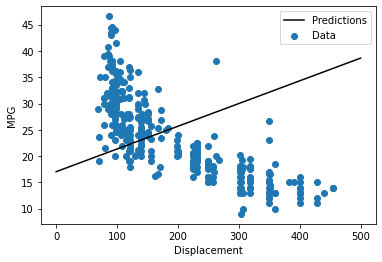

In [48]:
plot_displacement(fake.Displacement, linear_model(fake))

4. Visualize predicted MPG using the neural network model. Do you see an improvement/non-linearity from the linear model? 

10/10 [==============================] - 0s 2ms/step


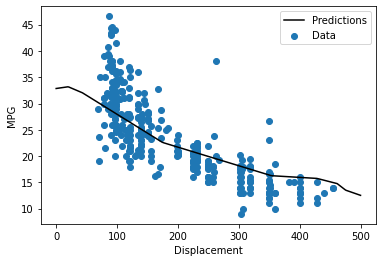

In [49]:
plot_displacement(fake.Displacement, dnn_model.predict(fake))

5. What are the other activation functions? Check the list of [activations](https://www.tensorflow.org/api_docs/python/tf/keras/activations). 
  
  Optional. Modify the DNN model with a different activation function, and fit it on the data; does it perform better? 

6. Overfitting is a common problem for DNN models, how should we deal with it? Check [Regularizers](https://www.tensorflow.org/api_docs/python/tf/keras/regularizers) on tf.keras. Any other techiniques that are invented for neural networks?

# Task 7 - MLflow Tracking

In this task, we briefly explore [MLflow Tracking](https://www.mlflow.org/docs/latest/tracking.html#tracking), one of four primary functions that MLflow offers for managing the end-to-end machine learning lifecycle. We will access the information runs programmatically in python and then set up the MLflow UI for easy interaction.

1. Experiments.

    MLflow Tracking is organized around the concept of `runs`, which are executions of some piece of modeling code; and runs are organized into experiments. 

    We set the auto logging in the beginning, we can verify that
    - there is one experiment
    - its name is `0`
    - all of its artifacts are stored at `file:///content/mlruns/0` in Google Drive.

In [50]:
from mlflow import MlflowClient
client = MlflowClient()
client.search_experiments() 

[<Experiment: artifact_location='file:///content/mlruns/0', creation_time=1675227528215, experiment_id='0', last_update_time=1675227528215, lifecycle_stage='active', name='Default', tags={}>]

2. Runs. 

   List information for runs that are under experiment '0' using [`mlflow.list_run_infos()`](https://www.mlflow.org/docs/latest/python_api/mlflow.html#mlflow.list_run_infos).

In [51]:
# YOUR CODE HERE
mlflow.search_runs()

,run_id,experiment_id,status,artifact_uri,start_time,end_time,metrics.loss,metrics.val_loss,params.shuffle,params.max_queue_size,...,params.validation_batch_size,params.epochs,params.opt_beta_2,params.validation_freq,tags.mlflow.source.name,tags.mlflow.user,tags.mlflow.source.type,tags.mlflow.runName,tags.mlflow.log-model.history,tags.mlflow.autologging
0,42a95d22850d4b21b512affbce56ec13,0,FINISHED,file:///content/mlruns/0/42a95d22850d4b21b512a...,2023-02-01 04:59:06.765000+00:00,2023-02-01 04:59:17.848000+00:00,10.647393,3.255409,True,10,...,None,100,0.999,1,/usr/local/lib/python3.8/dist-packages/ipykern...,root,LOCAL,legendary-tern-183,"[{""run_id"": ""42a95d22850d4b21b512affbce56ec13""...",tensorflow
1,53e34ecda9b34ab4975b1b7d7459d094,0,FINISHED,file:///content/mlruns/0/53e34ecda9b34ab4975b1...,2023-02-01 04:58:48.568000+00:00,2023-02-01 04:59:06.229000+00:00,3.222416,3.296942,True,10,...,None,100,0.999,1,/usr/local/lib/python3.8/dist-packages/ipykern...,root,LOCAL,bustling-bat-555,"[{""run_id"": ""53e34ecda9b34ab4975b1b7d7459d094""...",tensorflow


3. Retrieve the currently active run, i.e., the DNN model. Hint: `mlflow.last_active_run()` 

In [52]:
autolog_run = mlflow.last_active_run() # YOUR CODE HERE


4. Use function `print_auto_logged_info` provided below to fetch the auto logged parameters and metrics for `autolog_run`. 

In [53]:
import json
def print_auto_logged_info(r):
    tags = {k: v for k, v in r.data.tags.items() if not k.startswith("mlflow.")}
    artifacts = [f.path for f in MlflowClient().list_artifacts(r.info.run_id, "model")]
    print("run_id: {}".format(r.info.run_id))
    print("artifacts: {}".format(artifacts))
    print("params: {}".format(json.dumps(r.data.params, indent=4)))
    print("metrics: {}".format(r.data.metrics))
    print("tags: {}".format(tags))

In [54]:
print_auto_logged_info(
   autolog_run
    ) 

run_id: 42a95d22850d4b21b512affbce56ec13
artifacts: ['model/MLmodel', 'model/conda.yaml', 'model/data', 'model/python_env.yaml', 'model/requirements.txt']
params: {
    "opt_name": "Adam",
    "class_weight": "None",
    "validation_batch_size": "None",
    "sample_weight": "None",
    "opt_learning_rate": "0.001",
    "opt_amsgrad": "False",
    "opt_decay": "0.0",
    "opt_beta_2": "0.999",
    "shuffle": "True",
    "opt_epsilon": "1e-07",
    "validation_steps": "None",
    "max_queue_size": "10",
    "epochs": "100",
    "batch_size": "None",
    "validation_split": "0.2",
    "workers": "1",
    "steps_per_epoch": "None",
    "initial_epoch": "0",
    "use_multiprocessing": "False",
    "opt_beta_1": "0.9",
    "validation_freq": "1"
}
metrics: {'loss': 10.647393226623535, 'val_loss': 3.255408525466919}
tags: {}


5. Optional. Retrieve the best run using [MlflowClient().search_runs()](https://www.mlflow.org/docs/latest/search-runs.html#python).

In [55]:
runs = mlflow.search_runs() # YOUR CODE HERE

In [56]:
runs

,run_id,experiment_id,status,artifact_uri,start_time,end_time,metrics.loss,metrics.val_loss,params.shuffle,params.max_queue_size,...,params.validation_batch_size,params.epochs,params.opt_beta_2,params.validation_freq,tags.mlflow.source.name,tags.mlflow.user,tags.mlflow.source.type,tags.mlflow.runName,tags.mlflow.log-model.history,tags.mlflow.autologging
0,42a95d22850d4b21b512affbce56ec13,0,FINISHED,file:///content/mlruns/0/42a95d22850d4b21b512a...,2023-02-01 04:59:06.765000+00:00,2023-02-01 04:59:17.848000+00:00,10.647393,3.255409,True,10,...,None,100,0.999,1,/usr/local/lib/python3.8/dist-packages/ipykern...,root,LOCAL,legendary-tern-183,"[{""run_id"": ""42a95d22850d4b21b512affbce56ec13""...",tensorflow
1,53e34ecda9b34ab4975b1b7d7459d094,0,FINISHED,file:///content/mlruns/0/53e34ecda9b34ab4975b1...,2023-02-01 04:58:48.568000+00:00,2023-02-01 04:59:06.229000+00:00,3.222416,3.296942,True,10,...,None,100,0.999,1,/usr/local/lib/python3.8/dist-packages/ipykern...,root,LOCAL,bustling-bat-555,"[{""run_id"": ""53e34ecda9b34ab4975b1b7d7459d094""...",tensorflow


6. To see what's logged in the file system `/content/mlruns/`, click tab `files` in the left sidepanel in Colab. For example, 
    ```
    mlruns
    └── 0
        ├── 3a5aebdd35ef46fb8dc35b40e542f0a4
        │   ├── artifacts
        │   ├── meta.yaml
        │   ├── metrics
        │   ├── params
        │   └── tags
        ├── c627bc526c4a4c418a8285627e61a16d
        │   ├── artifacts
        │   ├── meta.yaml
        │   ├── metrics
        │   ├── params
        │   └── tags
        └── meta.yaml

    11 directories, 3 files
    ```

    Inspect the model summary of the DNN model you ran previously; it is located at `artifacts/model_summary.txt` of the corresponding run. Use `cat $filepath`. 

In [57]:
!cat $'/content/mlruns/0/'

cat: /content/mlruns/0/: Is a directory


7. Tracking UI. 

    MLflow provides an UI for us to visualize, search and compare runs, as well as download run artifacts or metadata for analysis in other tools. 

    If your runs are logged to a local mlruns directory, run `mlflow ui` in the directory above it will load the corresponding runs. 
    
    Running localhost server in Colab, however, requires a bit of extra work:
    - set up a free account on [ngrok](https://dashboard.ngrok.com/get-started/setup)
    - retrieve the authtoken from https://dashboard.ngrok.com/auth and update the code cell below
    
   **NOTE**. NEVER share your secrets. Best to keep `NGROK_AUTH_TOKEN` as an environment variable and retrieve it via `os.environ.get("NGROK_AUTH_TOKEN")`.

In [58]:
# run tracking UI in the background
get_ipython().system_raw("mlflow ui --port 5000 &") 

# create remote tunnel using ngrok.com to allow local port access
from pyngrok import ngrok
# Terminate open tunnels if exist
ngrok.kill()

# Setting the authtoken (see Note above)
NGROK_AUTH_TOKEN = "2EpLAwBPBxY5nlcuUvddGKOumUD_7pfLCJRhe9ku896xysV46"  # YOUR CODE HERE
ngrok.set_auth_token(NGROK_AUTH_TOKEN)

# Open an HTTPs tunnel on port 5000 for http://localhost:5000
ngrok_tunnel = ngrok.connect(addr="5000", proto="http", bind_tls=True)
print("MLflow Tracking UI:", ngrok_tunnel.public_url)

MLflow Tracking UI: https://08ac-34-125-47-4.ngrok.io


8. Interact with Tracking UI. 

    Open the link, output from the previous cell. get oriented, `Parameters`, `Metrics`, `Artifacts`, and so on.
    
    When you are done, make sure to terminate the open tunnel:

In [59]:
ngrok.kill()

# Task 8 - AutoML with TPOT 🫖

1. Instantiate and train a TPOT auto-ML regressor.

  The parameters are set fairly arbitrarily (if time permits, you shall experiment with different sets of parameters after reading [what each parameter does](http://epistasislab.github.io/tpot/api/#regression)). Use these parameter values:

  `generations`: 10

  `population_size`: 40

  `scoring`: negative mean absolute error; read more in [scoring functions in TPOT](http://epistasislab.github.io/tpot/using/#scoring-functions)

  `verbosity`: 2 (so you can see each generation's performance)

  The final line with create a Python script tpot_products_pipeline.py with the code to create the optimal model found by TPOT.

In [60]:
%%time
from tpot import TPOTRegressor
tpot = TPOTRegressor(generations=10, 
                     population_size=40,
                     scoring='neg_mean_absolute_error', # YOUR CODE HERE
                     verbosity=2,
                     random_state=42)
tpot.fit(train_features, train_labels)
print(f"Tpop score on test data: {tpot.score(test_features, test_labels):.2f}")
tpot.export('tpot_mpg_pipeline.py')

Optimization Progress:   0%|          | 0/440 [00:00<?, ?pipeline/s]


Generation 1 - Current best internal CV score: -2.105730490335792

Generation 2 - Current best internal CV score: -2.038700122615175

Generation 3 - Current best internal CV score: -2.038700122615175

Generation 4 - Current best internal CV score: -2.038700122615175

Generation 5 - Current best internal CV score: -2.0331198334046325

Generation 6 - Current best internal CV score: -2.0219752927120664

Generation 7 - Current best internal CV score: -2.0219752927120664

Generation 8 - Current best internal CV score: -2.021819901636769

Generation 9 - Current best internal CV score: -1.9993749174326267

Generation 10 - Current best internal CV score: -1.9993749174326267

Best pipeline: RandomForestRegressor(XGBRegressor(ZeroCount(input_matrix), learning_rate=0.1, max_depth=4, min_child_weight=2, n_estimators=100, n_jobs=1, objective=reg:squarederror, subsample=0.8, verbosity=0), bootstrap=False, max_features=0.3, min_samples_leaf=2, min_samples_split=8, n_estimators=100)
Tpop score on tes

2. Examine the model pipeline that TPOT regressor offers. If you see any model, function, or class that are not familiar, look them up! 

  Note: There is randomness to the way the TPOT searches, so it's possible you won't have exactly the same result as your classmate. 

In [61]:
cat tpot_mpg_pipeline.py

import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline, make_union
from tpot.builtins import StackingEstimator, ZeroCount
from xgboost import XGBRegressor
from tpot.export_utils import set_param_recursive

# NOTE: Make sure that the outcome column is labeled 'target' in the data file
tpot_data = pd.read_csv('PATH/TO/DATA/FILE', sep='COLUMN_SEPARATOR', dtype=np.float64)
features = tpot_data.drop('target', axis=1)
training_features, testing_features, training_target, testing_target = \
            train_test_split(features, tpot_data['target'], random_state=42)

# Average CV score on the training set was: -1.9993749174326267
exported_pipeline = make_pipeline(
    ZeroCount(),
    StackingEstimator(estimator=XGBRegressor(learning_rate=0.1, max_depth=4, min_child_weight=2, n_estimators=100, n_jobs=1, objective="reg:squarederror", subsample=0.8, verbosity=0)),
 

3. Take the appropriate lines (e.g., updating path to data and the variable names) from `tpot_mpg_pipeline.py` to build a model on our training set and make predictions on the test set. 
Save the predictions as `y_pred`, and compute appropriate evaluation metric. 
You may find that for this simple data set, the neural network we built outperforms the tree-based model, yet note it is not a conclusion that we can generalize for all tabular data. 

In [98]:
# NOTE: Make sure that the outcome column is labeled 'target' in the data file
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline, make_union
from tpot.builtins import StackingEstimator, ZeroCount
from xgboost import XGBRegressor
from tpot.export_utils import set_param_recursive
from sklearn import metrics 
tpot_data = dataset
tpot_data['target'] = tpot_data['MPG']
tpot_data.drop(['MPG'], axis = 1)
features = tpot_data.drop('target', axis=1)
training_features, testing_features, training_target, testing_target = \
            train_test_split(features, tpot_data['target'], train_size = 0.8, random_state=42)

# Average CV score on the training set was: -1.842208347231366
exported_pipeline = make_pipeline(
    ZeroCount(),
    StackingEstimator(estimator=XGBRegressor(learning_rate=0.1, max_depth=4, min_child_weight=2, n_estimators=100, n_jobs=1, objective="reg:squarederror", subsample=0.8, verbosity=0)),
    RandomForestRegressor(bootstrap=False, max_features=0.3, min_samples_leaf=2, min_samples_split=8, n_estimators=100)
)
# Fix random state for all the steps in exported pipeline
set_param_recursive(exported_pipeline.steps, 'random_state', 42)

exported_pipeline.fit(training_features, training_target)
y_pred = exported_pipeline.predict(testing_features)

err = metrics.mean_absolute_error(y_pred, testing_target)
err

0.4906045368338881

# Task 9 - Model Explainability

Last week, we introduced model explainability with SHAP and will continue to incorporate it as part our model output this week.  You can use the [Kernel Explainer](https://shap.readthedocs.io/en/latest/example_notebooks/tabular_examples/neural_networks/Census%20income%20classification%20with%20Keras.html) for explainability of both the Neural Networks and the TPOT classifier.  

In [127]:
import shap
# YOUR CODE GOES HERE!
explainer = shap.KernelExplainer(linear_model, training_features.iloc[10:15,1:])
shap_values = explainer.shap_values(training_features.iloc[10:15,1:], nsamples=500)
shap_values
#shap.force_plot(explainer.expected_value, shap_values[0], training_features.iloc[10,1:])

  0%|          | 0/5 [00:00<?, ?it/s]

[array([[ 0.93 ,  4.371, -1.749, -8.538, -0.1  , -2.751, -0.103,  0.045,
         -0.199],
        [-0.62 , -0.38 , -0.5  , -0.112,  0.   ,  0.239, -0.103,  0.045,
         -0.199],
        [ 0.93 , -0.164,  0.75 , -2.665,  0.764,  1.435,  0.412,  0.045,
          0.299],
        [-0.62 , -2.237,  1.686,  8.448, -0.299, -0.957, -0.103, -0.182,
          0.299],
        [-0.62 , -1.589, -0.187,  2.868, -0.365,  2.033, -0.103,  0.045,
         -0.199]])]

# Task 10 - Taking it to the Next Level! 📶

Let's take our models and make a model comparison demo like we did last week, but this time you're taking the lead!  
    
1. Save your training dataset as a CSV file so that it can be used in the Streamlit app.
1. Build a results DataFrame and save it as a CSV so that it can be used in the Streamlit app.
1. In Tab 1 - Raw Data:
* Display your training dataset in a Streamlit DataFrame (`st.DataFrame`).
* Build 1-2 interactive Plotly visualizations that explore the dataset (correlations, scatterplot, etc.)
2. In Tab 2 - Model Results:
* Display your performance metrics appropriately using 2-3 metrics for model comparison.
3. In Tab 3 - Model Explainability:
* Make local and global explainability plots to compare two models at a time side-by-side.  [Here](https://www.kaggle.com/code/elsa155026/uciheart-kernel-shap-and-interactive-visualization/notebook) is a good example if how to create some different explainability plots using Plotly.

In [141]:
#!pip install streamlit
import streamlit as st
training_features.to_csv('/content/sample_data/training_features')
stdf = st.dataframe(training_features)
stdf

StreamlitAPIException: ignored

# Additional Resources

- [Tensorflow playground](https://playground.tensorflow.org/) for an interactive experience to understand how nueral networkds work.

- [An Introduction to Deep Learning for Tabular Data](https://www.fast.ai/2018/04/29/categorical-embeddings/) covers embeddings for categorical variables. 

- [Imbalanced classification: credit card fraud detection](https://keras.io/examples/structured_data/imbalanced_classification/) demonstrates using `class_weight` to handle imbalanced classification problems. 

# Acknowledgement and Copyright

##### Acknowledgement

This notebook is adapted from [tensorflow/keras tuorial - regression](https://www.tensorflow.org/tutorials/keras/regression)

##### Copyright 2018 The TensorFlow Authors.

@title Licensed under the Apache License, Version 2.0 (the "License");
you may not use this file except in compliance with the License.
You may obtain a copy of the License at

https://www.apache.org/licenses/LICENSE-2.0

Unless required by applicable law or agreed to in writing, software
distributed under the License is distributed on an "AS IS" BASIS,
WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
See the License for the specific language governing permissions and
limitations under the License.

@title MIT License

Copyright (c) 2017 François Chollet

Permission is hereby granted, free of charge, to any person obtaining a
copy of this software and associated documentation files (the "Software"),
to deal in the Software without restriction, including without limitation
the rights to use, copy, modify, merge, publish, distribute, sublicense,
and/or sell copies of the Software, and to permit persons to whom the
Software is furnished to do so, subject to the following conditions:

The above copyright notice and this permission notice shall be included in
all copies or substantial portions of the Software.

THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR
IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY,
FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL
THE AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER
LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING
FROM, OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER
DEALINGS IN THE SOFTWARE.